In [1]:
import os
import skimage
import numpy as np
import matplotlib.pyplot as plt
from skimage import color,data,transform
from sklearn.utils import shuffle
import keras
from keras.utils import np_utils
import imageio

Using TensorFlow backend.


In [2]:
os.chdir('D://fruit-360')

In [3]:
def load_data(dir_path):
    images=[] ##Store pictures
    labels=[] ##Store lables
    no5_imgs=[] ##Store the 5th picture in each folder
    labels_no5=[] ##Store the 5th lables in each folder
    lab=os.listdir(dir_path)
    n=0
    for l in lab:
        img=os.listdir(dir_path+l) 
        for i in img:
            img_path=dir_path+l+'/'+i 
            labels.append(int(n)) 
            images.append(imageio.imread(img_path)) 
        n+=1
        no5_img=format_path(img) ##Arrange the pictures in the correct order to get the fifth picture
        img5_path=dir_path+l+'/'+no5_img
        labels_no5.append(l)
        no5_imgs.append(imageio.imread(img5_path)) ##The fifth picture of each category is read out and stored in the no5_imgs
    return images,labels,no5_imgs,labels_no5 


In [4]:
##Function to read files in folder in order
def format_path(img):     
    yes_int=[] ##New list is used to store the first file name that can be converted to an integer after segmentation
    for s in range(len(img)): 
        img[s] = img[s].split('_') ##Separate file names with'_'
        if(is_number(img[s][0])): ##Determine whether the first part of the file name after segmentation can be converted to integer
            img[s][0]=int(img[s][0]) ##Convert the first part of the file name to an integer
            yes_int.append(img[s]) ##Put the file name in the list without 'r'
    yes_int.sort() ##sort
    for yi in range(len(yes_int)): #
        yes_int[yi][0]=str(yes_int[yi][0]) ##convert to str
        yes_int[yi]=yes_int[yi][0]+'_'+yes_int[yi][1] ##joint
    no5_img=yes_int[4]
    return no5_img


In [5]:
##Judge whether the data can be converted to plastic
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False


In [6]:
##Training
images,labels,no5_imgs,labels_no5=load_data('.\Training\\')
print(len(images),len(labels),len(no5_imgs))

67692 67692 131


In [ ]:
##Test
images,labels,no5_imgs,labels_no5=load_data('.\Test\\')
print(len(images),len(labels),len(no5_imgs))

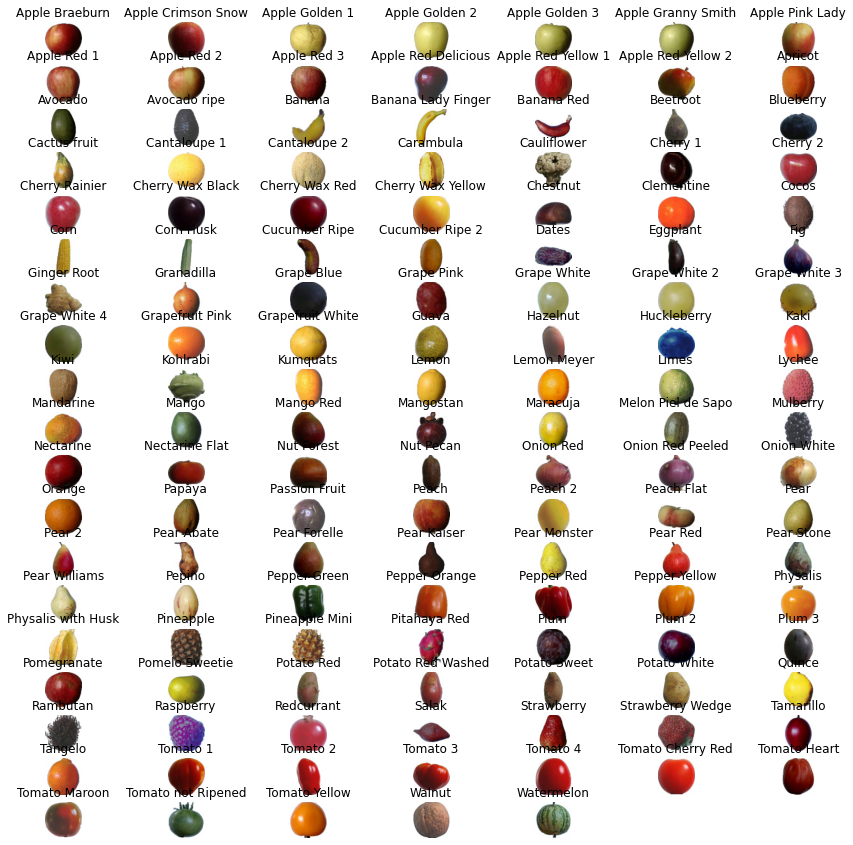

In [11]:
##Function
def display_no5_img(no5_imgs,labels_no5):
    fig = plt.figure(figsize=(15,15)) ##size
    for i in range(len(no5_imgs)):
        plt.subplot(19,7,(i+1)) ##10 pictures per line, 14 lines in total
        plt.title("{0}".format(labels_no5[i])) ##lables
        plt.imshow(no5_imgs[i])  ##pictures
        plt.axis('off') 
##Display
display_no5_img(no5_imgs,labels_no5) 

In [84]:
##n represents the number of categories
def load_small_data(dir_path,m):
    images_m=[] 
    labels_m=[] 
    lab=os.listdir(dir_path)
    n=0
    for l in lab:
        if(n>=m):
            break
        img=os.listdir(dir_path+l) 
        for i in img:
            img_path=dir_path+l+'/'+i
            labels_m.append(int(n)) 
            images_m.append(imageio.imread(img_path)) 
        n+=1
    return images_m,labels_m 


In [85]:
images_20,labels_20=load_small_data('.\Training\\',20) ##Training
images_test_20,labels_test_20=load_small_data('.\Test\\',20) ##Test

In [86]:
images_test_20,labels_test_20=load_small_data('.\Test\\',20) ##Test

In [87]:
def cut_image(images,w,h):
    new_images=[skimage.transform.resize(I,(w,h)) for I in images]
    return new_images

In [88]:
def cut_image(images,w,h):
    new_images=[skimage.transform.resize(I,(w,h)) for I in images]
    return new_images
def prepare_data(images,labels,n_classes):
    images64=cut_image(images,64,64) ##cut images
    train_x=np.array(images)
    train_y=np.array(labels)
    indx=np.arange(0,train_y.shape[0])
    indx=shuffle(indx)
    train_x=train_x[indx]
    train_y=train_y[indx]
    train_y=keras.utils.to_categorical(train_y,n_classes) ##one-hot one-hot encoding
    return train_x,train_y


In [89]:
##training data
train_x,train_y=prepare_data(images_20,labels_20,20)
##test data
test_x,test_y=prepare_data(images_test_20,labels_test_20,20)

In [90]:
##test data
test_x,test_y=prepare_data(images_test_20,labels_test_20,20)

In [91]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [92]:
## Configure the parameters of neural network
n_classes=20 ##number of classes
batch_size=128 ##size of batch
kernel_h=kernel_w=5 ##size of kernel
dropout=0.8 ##probability of dropout
depth_in=3 ##number of channels
depth_out1=64 ##number of kernels of 1st level
depth_out2=128 ##number of kernels of 2nd level
image_size=train_x.shape[1] ##size of image
n_sample=train_x.shape[0] ##number of training 
t_sample=test_x.shape[0] ##number of testing
 
##Image data types;Data volume of the first dimension training;Image size of 2nd and 3rd dimension ;Channel number of the fourth dimension image
x=tf.placeholder(tf.float32,[None,100,100,3]) 
y=tf.placeholder(tf.float32,[None,n_classes]) ##The type and shape of label data of feed to neural network
keep_prob=tf.placeholder(tf.float32) ##placeholder of dropout(Solving over-fitting)
fla=int((image_size*image_size/16)*depth_out2) ##Image size of flattening parameters after two-layer convolution pooling*number of kernels of 2nd level

##Define the weight variables of each build-up layer and fully connected layer
Weights={"con1_w":tf.Variable(tf.random_normal([kernel_h,kernel_w,depth_in,depth_out1])),
        "con2_w":tf.Variable(tf.random_normal([kernel_h,kernel_w,depth_out1,depth_out2])),
        "fc_w1":tf.Variable(tf.random_normal([int((image_size*image_size/16)*depth_out2),1024])),
        "fc_w2":tf.Variable(tf.random_normal([1024,512])),
        "out":tf.Variable(tf.random_normal([512,n_classes]))}
 
##Define the bias variables for each build-up layer and the fully connected layer
bias={"conv1_b":tf.Variable(tf.random_normal([depth_out1])),
      "conv2_b":tf.Variable(tf.random_normal([depth_out2])),
      "fc_b1":tf.Variable(tf.random_normal([1024])),
      "fc_b2":tf.Variable(tf.random_normal([512])),
      "out":tf.Variable(tf.random_normal([n_classes]))}


In [93]:
## Function of convolution layer
def conv2d(x,W,b,stride=1):
    x=tf.nn.conv2d(x,W,strides=[1,stride,stride,1],padding="SAME")
    x=tf.nn.bias_add(x,b)
    return tf.nn.relu(x)
 
## Function of pooling layer
def maxpool2d(x,stride=2):
    return tf.nn.max_pool(x,ksize=[1,stride,stride,1],strides=[1,stride,stride,1],padding="SAME")
 
## Function of Convolutional neural network 
def conv_net(x,weights,biases,dropout):
    
    ## Convolutional layer 1
    conv1 = conv2d(x,Weights['con1_w'],bias['conv1_b']) ##100*100*64
    conv1 = maxpool2d(conv1,2) ## shape：50*50*64
     
    ## Convolutional layer 2
    conv2 = conv2d(conv1,Weights['con2_w'],bias['conv2_b']) ##50*50*128
    conv2 = maxpool2d(conv2,2) ## shape:25*25*128
    ## Fully connected layer 1
    flatten = tf.reshape(conv2,[-1,fla]) ##Flatten
    fc1 = tf.add(tf.matmul(flatten,Weights['fc_w1']),bias['fc_b1'])
    fc1 = tf.nn.relu(fc1) ##relu
    print(flatten.get_shape())
    ## Fully connected layer 2
    fc2 = tf.add(tf.matmul(fc1,Weights['fc_w2']),bias['fc_b2']) ##output=input*weight+bias
    fc2 = tf.nn.relu(fc2) ##relu
    
    ## Dropout
    fc2 = tf.nn.dropout(fc2,dropout)
    ## Output class prediction
    prediction = tf.add(tf.matmul(fc2,Weights['out']),bias['out']) 
    return prediction


In [94]:
## Prediction
prediction=conv_net(x,Weights,bias,keep_prob) ##Convolutional neural network
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction,labels=y)) ##cross-entropy cost function
optimizer=tf.train.AdamOptimizer(0.0009).minimize(cross_entropy) ##Optimizer and learning rate

 
##Accuracy
correct_pred=tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(correct_pred,tf.float32))


(?, 80000)


In [95]:
##Divide the training data into blocks
def gen_small_data(inputs,batch_size):
    i=0
    while True:
        small_data=inputs[i:(batch_size+i)]
        i+=batch_size
        yield small_data


In [96]:
## training
with tf.Session() as sess:
    tf.global_variables_initializer().run()   
    for  i  in range(5):
        train_x,train_y=prepare_data(images_20,labels_20,20) ##prepare
        train_x=gen_small_data(train_x,batch_size) ##image
        train_y=gen_small_data(train_y,batch_size) ##lable
        for j in range(int(n_sample/batch_size)+1):
            x_=next(train_x) 
            y_=next(train_y)
            
            ##validate
            validate_feed={x:x_,y:y_,keep_prob:0.8}
            if i % 1 == 0:
                sess.run(optimizer, feed_dict=validate_feed)
                loss,acc = sess.run([cross_entropy,accuracy],feed_dict={x:x_,y:y_,keep_prob:0.8})
                print("Epoch:", '%04d' % (i+1),"cost=", "{:.9f}".format(loss),"Training accuracy","{:.5f}".format(acc))
    print('Optimization Completed')
    
    ##test
    test_x=test_x[0:400]
    test_y=test_y[0:400]
    test_feed={x:test_x,y:test_y,keep_prob: 0.8} 
    y1 = sess.run(prediction,feed_dict=test_feed)
    test_classes = np.argmax(y1,1)
    print('Testing Accuracy:',sess.run(accuracy,feed_dict=test_feed))


Epoch: 0001 cost= 4135453184.000000000 Training accuracy 0.08594
Epoch: 0001 cost= 3510798592.000000000 Training accuracy 0.09375
Epoch: 0001 cost= 3081003520.000000000 Training accuracy 0.09375
Epoch: 0001 cost= 3241513984.000000000 Training accuracy 0.08594
Epoch: 0001 cost= 2400627968.000000000 Training accuracy 0.15625
Epoch: 0001 cost= 2158143488.000000000 Training accuracy 0.18750
Epoch: 0001 cost= 2221193984.000000000 Training accuracy 0.14844
Epoch: 0001 cost= 1664543232.000000000 Training accuracy 0.19531
Epoch: 0001 cost= 1405350400.000000000 Training accuracy 0.29688
Epoch: 0001 cost= 1486363392.000000000 Training accuracy 0.31250
Epoch: 0001 cost= 1467071232.000000000 Training accuracy 0.24219
Epoch: 0001 cost= 1288884224.000000000 Training accuracy 0.30469
Epoch: 0001 cost= 1302712320.000000000 Training accuracy 0.24219
Epoch: 0001 cost= 989753728.000000000 Training accuracy 0.29688
Epoch: 0001 cost= 1069235072.000000000 Training accuracy 0.30469
Epoch: 0001 cost= 93599193

Epoch: 0002 cost= 14069324.000000000 Training accuracy 0.95312
Epoch: 0002 cost= 19471828.000000000 Training accuracy 0.92969
Epoch: 0002 cost= 17886302.000000000 Training accuracy 0.92188
Epoch: 0002 cost= 12079199.000000000 Training accuracy 0.94531
Epoch: 0002 cost= 18906378.000000000 Training accuracy 0.92969
Epoch: 0002 cost= 18480600.000000000 Training accuracy 0.92969
Epoch: 0002 cost= 8315671.000000000 Training accuracy 0.95312
Epoch: 0002 cost= 4042306.000000000 Training accuracy 0.95312
Epoch: 0002 cost= 8741764.000000000 Training accuracy 0.94531
Epoch: 0002 cost= 18320940.000000000 Training accuracy 0.95312
Epoch: 0002 cost= 16479216.000000000 Training accuracy 0.93750
Epoch: 0002 cost= 24306664.000000000 Training accuracy 0.89062
Epoch: 0002 cost= 15196282.000000000 Training accuracy 0.90625
Epoch: 0002 cost= 14136292.000000000 Training accuracy 0.91406
Epoch: 0002 cost= 18589484.000000000 Training accuracy 0.93750
Epoch: 0002 cost= 12060665.000000000 Training accuracy 0.9

Epoch: 0004 cost= 8714720.000000000 Training accuracy 0.96875
Epoch: 0004 cost= 265998.000000000 Training accuracy 0.99219
Epoch: 0004 cost= 9264874.000000000 Training accuracy 0.96875
Epoch: 0004 cost= 10056854.000000000 Training accuracy 0.94531
Epoch: 0004 cost= 7594086.500000000 Training accuracy 0.96875
Epoch: 0004 cost= 1517461.000000000 Training accuracy 0.98438
Epoch: 0004 cost= 14621300.000000000 Training accuracy 0.94531
Epoch: 0004 cost= 10852815.000000000 Training accuracy 0.95312
Epoch: 0004 cost= 1819464.000000000 Training accuracy 0.98438
Epoch: 0004 cost= 7652019.000000000 Training accuracy 0.96875
Epoch: 0004 cost= 10281488.000000000 Training accuracy 0.95312
Epoch: 0004 cost= 6508370.000000000 Training accuracy 0.95312
Epoch: 0004 cost= 5383023.000000000 Training accuracy 0.98438
Epoch: 0004 cost= 1954763.500000000 Training accuracy 0.98438
Epoch: 0004 cost= 8559962.000000000 Training accuracy 0.96094
Epoch: 0004 cost= 5672162.500000000 Training accuracy 0.97656
Epoch

In [ ]:
# Visualisation
model = make_model(image_size, n_classes)
model.load_weights('save_best.h5')

import numpy as np
import cv2
import os

import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.applications.resnet import ResNet50

def make_model(input_size, n_classes):
    input = keras.Input(shape=(image_size, image_size, 3))
    res = ResNet50(include_top=False, weights=None, classes = n_classes, input_tensor=input)
    x = res.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(n_classes * 2, activation='relu')(x)
    x = layers.Dense(n_classes, activation='softmax')(x)
    return keras.Model(input, x)

CLASS_MAP = {
    0:'Apple Braeburn',
    1:'Apple Crimson Snow',
    2:'Apple Golden 1',
    3:'Apple Golden 2',
    4:'Apple Golden 3',
    5:'Apple Granny Smith',
    6:'Apple Pink Lady',
    7:'Apple Red 1',
    8:'Apple Red 2',
    9:'Apple Red 3',
    10:'banana',
    11:'Apple Red Y 1',
    12:'Apple Red Y 2',
    13:'Apricot',
    14:'Avocado',
    15:'Avocado ripe',
    16:'Banana',
    17:'Banana Lady Finger',
    18:'apple',
    19:'Beetroot',   
}

def video_demo():
    model = make_model((100, 100, 3), 20)
    model.load_weights('save_best.h5')
    # read images
    # 0 represents the camera number. If there is only one camera, the default value is 0
    capture = cv2.VideoCapture(0)
    while (True):
        ref, image = capture.read()
        (H, W) = image.shape[:2]  # read the width and height of images
        img = cv2.resize(image, (100, 100))
        img = img[np.newaxis, :]
        y = model.predict(img)[0]
        idx = np.argmax(y)
        cv2.putText(image, 'type:%s   ,  probability:%.2f'%(CLASS_MAP[idx], y[idx]), (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.5, [1,0,0], 2)
        cv2.imshow("Image", image)
        #Wait for 30 ms to display the image
        #Press "ESC" to exit
        c = cv2.waitKey(30) & 0xff
        if c == 27:
            capture.release()
            break
            
video_demo()